https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


In [3]:

df = pd.read_csv(csv_path).drop_duplicates('Date Time')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df['date'] = date_time


In [4]:

LABELS = ['T (degC)']
REGRESSORS = ['p (mbar)']#, 'rh (%)']
DATE = 'date'
IN_STEPS = 24
OUT_STEPS = 24
GROUPBY = ['SeriesID']
BATCH_SIZE = 8

In [5]:
series_1 = df[LABELS + REGRESSORS + [DATE]]
series_1.loc[:, 'SeriesID'] = 1

series_2 = df[LABELS + REGRESSORS + [DATE]]
series_2.loc[:, 'SeriesID'] = 2

series_3 = df[LABELS + REGRESSORS + [DATE]]
series_3.loc[:, 'SeriesID'] = 3

series = pd.concat([series_1, series_2, series_3], axis=0).reset_index(drop=True)
series

<ipython-input-5-1dc4c9d78392>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_1.loc[:, 'SeriesID'] = 1
<ipython-input-5-1dc4c9d78392>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_2.loc[:, 'SeriesID'] = 2
<ipython-input-5-1dc4c9d78392>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,T (degC),p (mbar),date,SeriesID
0,-8.05,996.50,2009-01-01 01:00:00,1
1,-8.88,996.62,2009-01-01 02:00:00,1
2,-8.81,996.84,2009-01-01 03:00:00,1
3,-9.05,996.99,2009-01-01 04:00:00,1
4,-9.63,997.46,2009-01-01 05:00:00,1
...,...,...,...,...
210106,-1.61,1001.78,2016-12-31 19:40:00,3
210107,-3.30,1001.39,2016-12-31 20:40:00,3
210108,-2.48,1001.00,2016-12-31 21:40:00,3
210109,-4.45,1000.45,2016-12-31 22:40:00,3


In [6]:

n = len(df)
train_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:int(n * 0.7)]).reset_index(drop=True)
val_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.7):int(n * 0.9)]).reset_index(drop=True)
test_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

((147075, 4), (42024, 4), (21012, 4))

In [7]:

train_series[GROUPBY].value_counts()

SeriesID
1           49025
2           49025
3           49025
dtype: int64

In [8]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    self.GROUPBY = GROUPBY
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}',
        f'GROUPBY column(s): {self.GROUPBY}'
        ])

In [9]:
GROUPBY

['SeriesID']

In [10]:
by = GROUPBY +[DATE]

In [11]:
def preprocess_dataset(self:MultiSeriesWindowsGenerator, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index()

      by = self.GROUPBY + [DATE]
      labels = self.label_columns + self.regressor_columns + self.static_columns
      print("labels --> ",labels, " static_columns --< ", self.static_columns)
      data = data.set_index(by).unstack(-1)
      data = tf.stack([data[label] for label in labels], axis=-1)

      if data.ndim != 3:
          data = data[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return data

def update_datasets(self:MultiSeriesWindowsGenerator, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm:
      train_mean = tf.reduce_mean(self.train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(self.train_df, axis=1, keepdims=True)

      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      self.train_mean = train_mean
      self.train_std = train_std
      self.norm = norm

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}

MultiSeriesWindowsGenerator.preprocess_dataset = preprocess_dataset
MultiSeriesWindowsGenerator.update_datasets = update_datasets

In [12]:
train_series

,T (degC),p (mbar),date,SeriesID
0,-8.05,996.50,2009-01-01 01:00:00,1
1,-8.88,996.62,2009-01-01 02:00:00,1
2,-8.81,996.84,2009-01-01 03:00:00,1
3,-9.05,996.99,2009-01-01 04:00:00,1
4,-9.63,997.46,2009-01-01 05:00:00,1
...,...,...,...,...
147070,20.69,991.17,2014-08-05 13:40:00,3
147071,22.13,991.07,2014-08-05 14:40:00,3
147072,21.40,991.31,2014-08-05 15:40:00,3
147073,19.45,991.55,2014-08-05 16:40:00,3


In [13]:
train_series[:10]

,T (degC),p (mbar),date,SeriesID
0,-8.05,996.50,2009-01-01 01:00:00,1
1,-8.88,996.62,2009-01-01 02:00:00,1
2,-8.81,996.84,2009-01-01 03:00:00,1
3,-9.05,996.99,2009-01-01 04:00:00,1
4,-9.63,997.46,2009-01-01 05:00:00,1
5,-9.67,997.71,2009-01-01 06:00:00,1
6,-9.17,998.33,2009-01-01 07:00:00,1
7,-8.10,999.17,2009-01-01 08:00:00,1
8,-7.66,999.69,2009-01-01 09:00:00,1
9,-7.04,1000.27,2009-01-01 10:00:00,1


In [14]:
train_series[49025:49035]

,T (degC),p (mbar),date,SeriesID
49025,-8.05,996.50,2009-01-01 01:00:00,2
49026,-8.88,996.62,2009-01-01 02:00:00,2
49027,-8.81,996.84,2009-01-01 03:00:00,2
49028,-9.05,996.99,2009-01-01 04:00:00,2
49029,-9.63,997.46,2009-01-01 05:00:00,2
49030,-9.67,997.71,2009-01-01 06:00:00,2
49031,-9.17,998.33,2009-01-01 07:00:00,2
49032,-8.10,999.17,2009-01-01 08:00:00,2
49033,-7.66,999.69,2009-01-01 09:00:00,2
49034,-7.04,1000.27,2009-01-01 10:00:00,2


In [15]:
train_series[98050:98060]

,T (degC),p (mbar),date,SeriesID
98050,-8.05,996.50,2009-01-01 01:00:00,3
98051,-8.88,996.62,2009-01-01 02:00:00,3
98052,-8.81,996.84,2009-01-01 03:00:00,3
98053,-9.05,996.99,2009-01-01 04:00:00,3
98054,-9.63,997.46,2009-01-01 05:00:00,3
98055,-9.67,997.71,2009-01-01 06:00:00,3
98056,-9.17,998.33,2009-01-01 07:00:00,3
98057,-8.10,999.17,2009-01-01 08:00:00,3
98058,-7.66,999.69,2009-01-01 09:00:00,3
98059,-7.04,1000.27,2009-01-01 10:00:00,3


In [16]:
small_data = pd.concat([train_series[:5],train_series[49025:49030],train_series[98050:98055]])
small_data

,T (degC),p (mbar),date,SeriesID
0,-8.05,996.50,2009-01-01 01:00:00,1
1,-8.88,996.62,2009-01-01 02:00:00,1
2,-8.81,996.84,2009-01-01 03:00:00,1
3,-9.05,996.99,2009-01-01 04:00:00,1
4,-9.63,997.46,2009-01-01 05:00:00,1
49025,-8.05,996.50,2009-01-01 01:00:00,2
49026,-8.88,996.62,2009-01-01 02:00:00,2
49027,-8.81,996.84,2009-01-01 03:00:00,2
49028,-9.05,996.99,2009-01-01 04:00:00,2
49029,-9.63,997.46,2009-01-01 05:00:00,2


In [17]:
small_data.set_index(by)

T (degC)  p (mbar)
SeriesID date                                   
1        2009-01-01 01:00:00     -8.05    996.50
         2009-01-01 02:00:00     -8.88    996.62
         2009-01-01 03:00:00     -8.81    996.84
         2009-01-01 04:00:00     -9.05    996.99
         2009-01-01 05:00:00     -9.63    997.46
2        2009-01-01 01:00:00     -8.05    996.50
         2009-01-01 02:00:00     -8.88    996.62
         2009-01-01 03:00:00     -8.81    996.84
         2009-01-01 04:00:00     -9.05    996.99
         2009-01-01 05:00:00     -9.63    997.46
3        2009-01-01 01:00:00     -8.05    996.50
         2009-01-01 02:00:00     -8.88    996.62
         2009-01-01 03:00:00     -8.81    996.84
         2009-01-01 04:00:00     -9.05    996.99
         2009-01-01 05:00:00     -9.63    997.46

In [18]:
data1 = small_data.set_index(by).unstack(-1)
data1

T (degC)                                          \
date     2009-01-01 01:00:00 2009-01-01 02:00:00 2009-01-01 03:00:00   
SeriesID                                                               
1                      -8.05               -8.88               -8.81   
2                      -8.05               -8.88               -8.81   
3                      -8.05               -8.88               -8.81   

                                                            p (mbar)  \
date     2009-01-01 04:00:00 2009-01-01 05:00:00 2009-01-01 01:00:00   
SeriesID                                                               
1                      -9.05               -9.63               996.5   
2                      -9.05               -9.63               996.5   
3                      -9.05               -9.63               996.5   

                                                                      \
date     2009-01-01 02:00:00 2009-01-01 03:00:00 2009-01-01 04:00:00   
SeriesID                                                               
1                     996.62              996.84              996.99   
2                     996.62              996.84              996.99   
3                     996.62              996.84              996.99   

                              
date     2009-01-01 05:00:00  
SeriesID                      
1                     997.46  
2                     997.46  
3                     997.46

In [19]:
data1.shape

(3, 10)

In [20]:
data1['T (degC)']

date,2009-01-01 01:00:00,2009-01-01 02:00:00,2009-01-01 03:00:00,2009-01-01 04:00:00,2009-01-01 05:00:00
SeriesID,,,,,
1,-8.05,-8.88,-8.81,-9.05,-9.63
2,-8.05,-8.88,-8.81,-9.05,-9.63
3,-8.05,-8.88,-8.81,-9.05,-9.63


In [21]:
data1['p (mbar)']

date,2009-01-01 01:00:00,2009-01-01 02:00:00,2009-01-01 03:00:00,2009-01-01 04:00:00,2009-01-01 05:00:00
SeriesID,,,,,
1,996.5,996.62,996.84,996.99,997.46
2,996.5,996.62,996.84,996.99,997.46
3,996.5,996.62,996.84,996.99,997.46


In [22]:
#data1['rh (%)']


In [23]:
np.array([1,2,3,4]).reshape(-1,1)

array([[1],
       [2],
       [3],
       [4]])

In [24]:
np.array([[1,2,3,4],[4,5,6,7],[7,8,9,10]]).shape

(3, 4)

In [25]:
np.array([[1,2,3,4],[4,5,6,7],[7,8,9,10]]).T

array([[ 1,  4,  7],
       [ 2,  5,  8],
       [ 3,  6,  9],
       [ 4,  7, 10]])

In [26]:
tf.stack([[1,2,3,4],[4,5,6,7],[7,8,9,10]])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 4,  5,  6,  7],
       [ 7,  8,  9, 10]], dtype=int32)>

In [27]:
tf.stack([[1,2,3,4],[4,5,6,7],[7,8,9,10]], axis=-1)

<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[ 1,  4,  7],
       [ 2,  5,  8],
       [ 3,  6,  9],
       [ 4,  7, 10]], dtype=int32)>

In [28]:
np.array([[1,2,3],[4,5,6]]).shape

(2, 3)

In [29]:
np.array([[1,2,3],[4,5,6]]).T

array([[1, 4],
       [2, 5],
       [3, 6]])

In [30]:
tf.stack([[1,2,3],[4,5,6]], axis=-1)

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]], dtype=int32)>

In [31]:
tf.stack([data1['T (degC)'],data1['p (mbar)']])#,data1['rh (%)']])

<tf.Tensor: shape=(2, 3, 5), dtype=float64, numpy=
array([[[ -8.05,  -8.88,  -8.81,  -9.05,  -9.63],
        [ -8.05,  -8.88,  -8.81,  -9.05,  -9.63],
        [ -8.05,  -8.88,  -8.81,  -9.05,  -9.63]],

       [[996.5 , 996.62, 996.84, 996.99, 997.46],
        [996.5 , 996.62, 996.84, 996.99, 997.46],
        [996.5 , 996.62, 996.84, 996.99, 997.46]]])>

In [32]:
tf.stack([data1['T (degC)'],data1['p (mbar)']], axis=-1)

<tf.Tensor: shape=(3, 5, 2), dtype=float64, numpy=
array([[[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]],

       [[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]],

       [[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]]])>

In [33]:
data2 = tf.stack([data1[label] for label in ['T (degC)', 'p (mbar)']], axis=-1)#, 'rh (%)']], axis=-1)
data2

<tf.Tensor: shape=(3, 5, 2), dtype=float64, numpy=
array([[[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]],

       [[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]],

       [[ -8.05, 996.5 ],
        [ -8.88, 996.62],
        [ -8.81, 996.84],
        [ -9.05, 996.99],
        [ -9.63, 997.46]]])>

In [34]:
data2.ndim

3

In [35]:
w1 = MultiSeriesWindowsGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=BATCH_SIZE, label_columns=LABELS, GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w1.update_datasets(train_series, val_series, test_series, norm=True)

labels -->  ['T (degC)', 'p (mbar)']  static_columns --<  []
labels -->  ['T (degC)', 'p (mbar)']  static_columns --<  []
labels -->  ['T (degC)', 'p (mbar)']  static_columns --<  []


In [36]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)']
GROUPBY column(s): ['SeriesID']

In [37]:
def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    print(labels)
    print(self.label_columns)
    if self.label_columns is not None:
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]]
          for name in self.label_columns], axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
MultiSeriesWindowsGenerator.split_window = split_window

In [38]:
series_1.shape

(70037, 4)

In [39]:
series_1.set_index(GROUPBY + [DATE]).shape

(70037, 2)

In [40]:
w1.input_slice

slice(0, 24, None)

In [41]:
slice1 = slice(0,7)
slice1

slice(0, 7, None)

In [42]:

example_window = tf.stack([
    np.array(series_1.set_index(GROUPBY + [DATE])[:w1.total_window_size]),
    np.array(series_1.set_index(GROUPBY + [DATE])[2:2+w1.total_window_size]),
    np.array(series_1.set_index(GROUPBY + [DATE])[4:4+w1.total_window_size])
])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

tf.Tensor(
[[[  -4.44  999.34]
  [  -4.29  998.93]
  [  -4.45  998.69]
  [  -4.58  998.32]
  [  -4.96  998.1 ]
  [  -4.43  998.  ]
  [  -4.28  998.17]
  [  -4.33  998.18]
  [  -4.13  998.35]
  [  -3.93  998.65]
  [  -3.62  998.98]
  [  -3.12  998.91]
  [  -2.53  998.59]
  [  -2.56  998.73]
  [  -2.12  998.87]
  [  -2.76  999.59]
  [  -2.88 1000.21]
  [  -3.07 1000.74]
  [  -3.34 1001.27]
  [  -3.3  1001.83]
  [  -3.49 1002.23]
  [  -4.02 1002.39]
  [  -4.38 1002.52]
  [  -4.71 1002.32]]

 [[  -4.45  998.69]
  [  -4.58  998.32]
  [  -4.96  998.1 ]
  [  -4.43  998.  ]
  [  -4.28  998.17]
  [  -4.33  998.18]
  [  -4.13  998.35]
  [  -3.93  998.65]
  [  -3.62  998.98]
  [  -3.12  998.91]
  [  -2.53  998.59]
  [  -2.56  998.73]
  [  -2.12  998.87]
  [  -2.76  999.59]
  [  -2.88 1000.21]
  [  -3.07 1000.74]
  [  -3.34 1001.27]
  [  -3.3  1001.83]
  [  -3.49 1002.23]
  [  -4.02 1002.39]
  [  -4.38 1002.52]
  [  -4.71 1002.32]
  [  -5.28 1002.39]
  [  -6.23 1002.27]]

 [[  -4.96  998.1 ]
  [  

In [43]:
example_window[:,0:7,:]

<tf.Tensor: shape=(3, 7, 2), dtype=float64, numpy=
array([[[  -8.05,  996.5 ],
        [  -8.88,  996.62],
        [  -8.81,  996.84],
        [  -9.05,  996.99],
        [  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33]],

       [[  -8.81,  996.84],
        [  -9.05,  996.99],
        [  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33],
        [  -8.1 ,  999.17],
        [  -7.66,  999.69]],

       [[  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33],
        [  -8.1 ,  999.17],
        [  -7.66,  999.69],
        [  -7.04, 1000.27],
        [  -7.41, 1000.87]]])>

In [44]:
example_window[:,slice1,:]

<tf.Tensor: shape=(3, 7, 2), dtype=float64, numpy=
array([[[  -8.05,  996.5 ],
        [  -8.88,  996.62],
        [  -8.81,  996.84],
        [  -9.05,  996.99],
        [  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33]],

       [[  -8.81,  996.84],
        [  -9.05,  996.99],
        [  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33],
        [  -8.1 ,  999.17],
        [  -7.66,  999.69]],

       [[  -9.63,  997.46],
        [  -9.67,  997.71],
        [  -9.17,  998.33],
        [  -8.1 ,  999.17],
        [  -7.66,  999.69],
        [  -7.04, 1000.27],
        [  -7.41, 1000.87]]])>

In [45]:
w1.example = (example_inputs, example_labels)

In [46]:


def plot(self, model=None, plot_col=LABELS[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [MS]')

MultiSeriesWindowsGenerator.plot = plot

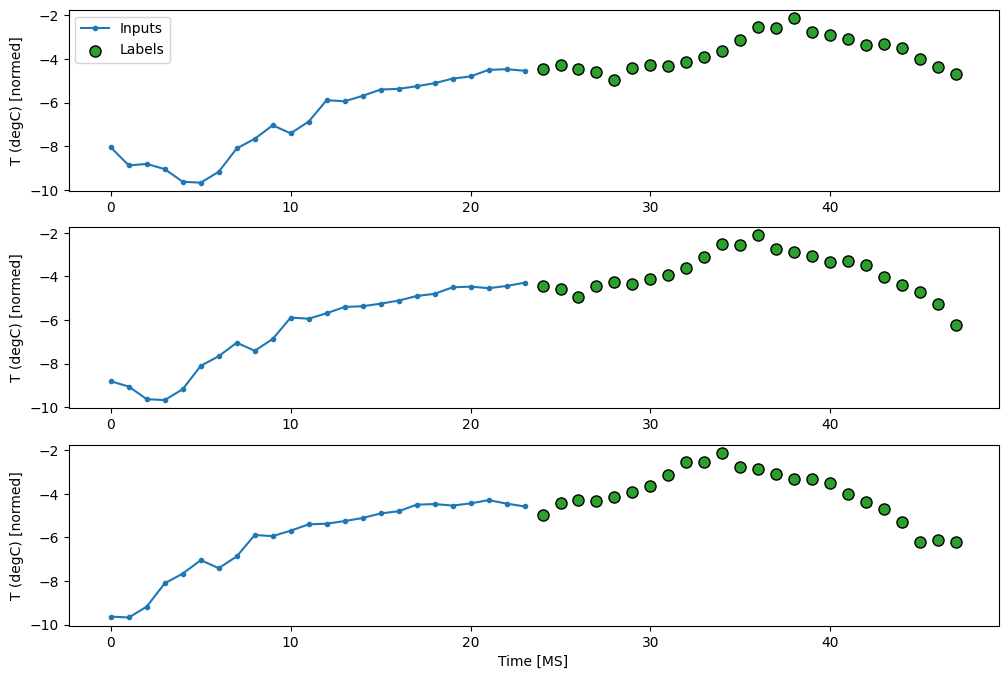

In [47]:

w1.plot()

In [48]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32)
    print(data.shape)
    ds = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size
    )
    print("ds --> ",ds)
    ds = ds.map(self.split_window)
    return ds

MultiSeriesWindowsGenerator.make_cohort = make_cohort


In [49]:
series_1.shape

(70037, 4)

In [50]:
series_1.set_index(GROUPBY + [DATE]).shape

(70037, 2)

In [51]:
ds_list1 = w1.make_cohort(series_1.set_index(GROUPBY + [DATE]))

(70037, 2)
ds -->  <_BatchDataset element_spec=TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None)>
Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float32)
['T (degC)']


In [52]:
ds_list1

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [53]:
ds_list1.element_spec

(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [54]:
"""
Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0)
    labels = tf.concat([window[1] for window in windows], 0)
    return (features, labels)

def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    print("ds_list -- >", ds_list)
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch()
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(1)
    return ds

MultiSeriesWindowsGenerator.make_dataset = make_dataset


In [55]:
w1.train_df

<tf.Tensor: shape=(3, 49025, 2), dtype=float64, numpy=
array([[[-1.98229387,  0.94481285],
        [-2.07822956,  0.95927115],
        [-2.0701386 ,  0.98577803],
        ...,
        [ 1.42168947,  0.31949147],
        [ 1.19629838,  0.34840806],
        [ 1.25293511,  0.33635948]],

       [[-1.98229387,  0.94481285],
        [-2.07822956,  0.95927115],
        [-2.0701386 ,  0.98577803],
        ...,
        [ 1.42168947,  0.31949147],
        [ 1.19629838,  0.34840806],
        [ 1.25293511,  0.33635948]],

       [[-1.98229387,  0.94481285],
        [-2.07822956,  0.95927115],
        [-2.0701386 ,  0.98577803],
        ...,
        [ 1.42168947,  0.31949147],
        [ 1.19629838,  0.34840806],
        [ 1.25293511,  0.33635948]]])>

In [56]:
w1.train_df.shape

TensorShape([3, 49025, 2])

In [57]:
tuple(i for i in range(3))

(0, 1, 2)

In [58]:
len(w1.train_df)

3

In [59]:
w1.make_dataset(w1.train_df)

(49025, 2)
ds -->  <_BatchDataset element_spec=TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None)>
Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float32)
['T (degC)']
(49025, 2)
ds -->  <_BatchDataset element_spec=TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None)>
Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float32)
['T (degC)']
(49025, 2)
ds -->  <_BatchDataset element_spec=TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None)>
Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float32)
['T (degC)']
ds_list -- > (<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(Non

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [60]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None)
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

MultiSeriesWindowsGenerator.train = train
MultiSeriesWindowsGenerator.test = test
MultiSeriesWindowsGenerator.val = val
MultiSeriesWindowsGenerator.example = example

In [21]:

for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 24, 3)
Labels shape (batch, time, features): (8, 24, 1)


Number of train batches: 18367


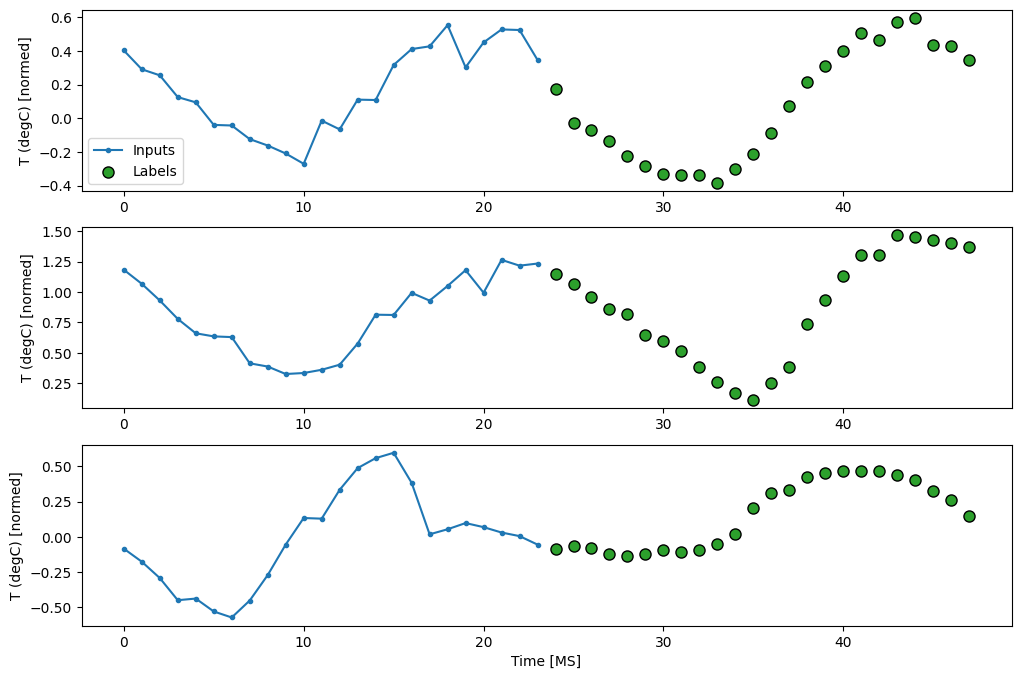

In [22]:

w1.plot()

In [23]:
single_step_window = MultiSeriesWindowsGenerator(
    input_width=1, label_width=1, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY, label_columns=LABELS, regressor_columns=REGRESSORS)
single_step_window.update_datasets(train_series, val_series, test_series, norm=True)

In [24]:

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [25]:

baseline = Baseline(label_index=single_step_window.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5253/5253 [==============================] - 11s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0789


In [26]:

wide_window = MultiSeriesWindowsGenerator(
    input_width=24, label_width=24, shift=1, batch_size=BATCH_SIZE, GROUPBY = GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS)
wide_window.update_datasets(train_series, val_series, test_series, norm=True)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)', 'rh (%)']
GROUPBY column(s): ['SeriesID']

Number of train batches: 18376


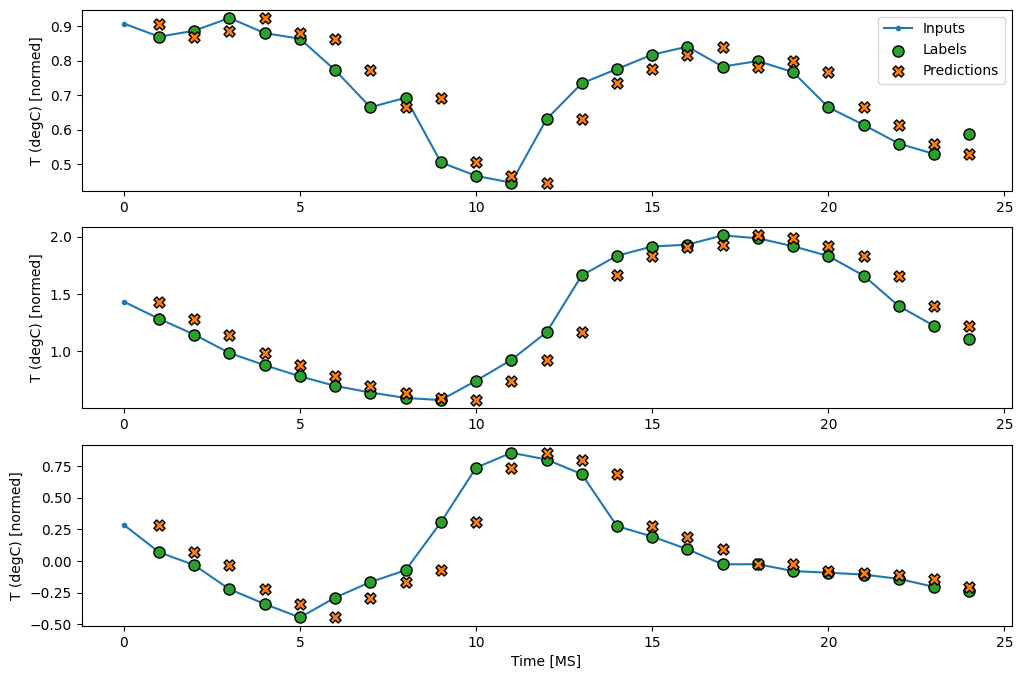

In [27]:

wide_window.plot(baseline)